In [1]:
import radarsimpy

print("`RadarSimPy` used in this example is version: " + str(radarsimpy.__version__))

`RadarSimPy` used in this example is version: 12.6.1


# Micro-Doppler

## Introduction

Micro-Doppler is a fascinating and important phenomenon in radar and remote sensing. It refers to the tiny, high-frequency Doppler shifts in the radar return signal caused by the motion of sub-components or features within a target or object. Unlike traditional Doppler radar, which primarily detects the motion of entire objects, micro-Doppler enables the detection and analysis of the complex, fine-scale motion patterns of components or parts within an object.

Micro-Doppler signatures can reveal valuable information about the internal structure, orientation, and movement of objects or biological entities, such as humans, animals, or vehicles. This technology has diverse applications, ranging from identifying concealed weapons or explosives on a person to classifying and tracking moving parts within machinery or vehicles.

In essence, micro-Doppler radar has revolutionized our ability to examine and understand the intricate dynamics and behaviors of objects at a granular level, making it a crucial tool in various fields, including security, defense, transportation, and healthcare.

In this demonstration, we harness the formidable ray tracing capabilities offered by [`RadarSimPy`](https://radarsimx.com/radarsimx/radarsimpy/) to simulate the micro-Doppler signature generated by a rotating turbine.

## Create Radar Model

Firstly, import the required modules from `radarsimpy`. `numpy` will also be needed in this example.


In [2]:
import numpy as np
from radarsimpy import Radar, Transmitter, Receiver

### Transmitter

Setup the basic transmitter parameters through [Transmitter](https://radarsimx.github.io/radarsimpy/radar.html#radarsimpy-transmitter) module.

#### Define a Radar Transmitter

As shown in the diagram below, `f` and `t` are used to define the waveform modulation. For a linear frequency-modulated continuous waveform (FMCW), it can be specified as `f = [fstart, fend]` and `t = [tstart, tend]`. If `t` is a single number `t = t0`, which is equivalent to `t = [0, t0]`. The bandwidth of the FMCW is `abs(fstart - fend)`. `prp` is the pulse repetition period, and `prp >= (tend - tstart)`.

```
|                       prp
|                  +-----------+
|
|            +---f[1]--->  /            /            /
|                         /            /            /
|                        /            /            /
|                       /            /            /
|                      /            /            /     ...
|                     /            /            /
|                    /            /            /
|                   /            /            /
|      +---f[0]--->/            /            /
|
|                  +-------+
|                 t[0]    t[1]
```


In [3]:
tx_channel = dict(
    location=(0, 0, 0),
)

tx = Transmitter(
    f=[24e9 - 4000e6, 24e9 + 4000e6],
    t=300e-6,
    tx_power=25,
    prp=0.0025,
    pulses=1280,
    channels=[tx_channel],
)

### Receiver

Setup the receiver parameters through [Receiver](https://radarsimx.github.io/radarsimpy/radar.html#radarsimpy-receiver) module.

#### Define a Radar Receiver

- `fs` – Sampling rate (sps)
- `noise_figure` – Noise figure (dB)
- `rf_gain` – Total RF gain (dB)
- `load_resistor` – Load resistor to convert power to voltage (Ohm)
- `baseband_gain` – Total baseband gain (dB)


In [4]:
rx_channel = dict(
    location=(0, 0, 0),
)

rx = Receiver(
    fs=2e6,
    noise_figure=6,
    rf_gain=20,
    load_resistor=500,
    baseband_gain=30,
    channels=[rx_channel],
)

### Radar System

Use the defined transmitter and receiver to create the radar system.


In [5]:
radar = Radar(transmitter=tx, receiver=rx)

## Target Model

Load the stl model of the target and set the `location`, `speed`, `rotation`, and `rotation_rate` of the target.

- `location`: (x, y, z) m
- `speed`: (x, y, z) m/s
- `rotation`: (yaw, pitch, roll) degree
- `rotation_rate`: (yaw, pitch, roll) degree/s


In [6]:
target_1 = {
    "model": "../models/turbine.stl",
    "unit": "m",
    "location": (5, 0, 0),
    "rotation": (0, 0, 0),
    "rotation_rate": (0, 30, 0),
    "speed": (0, 0, 0),
}

targets = [target_1]

_Plot the model_


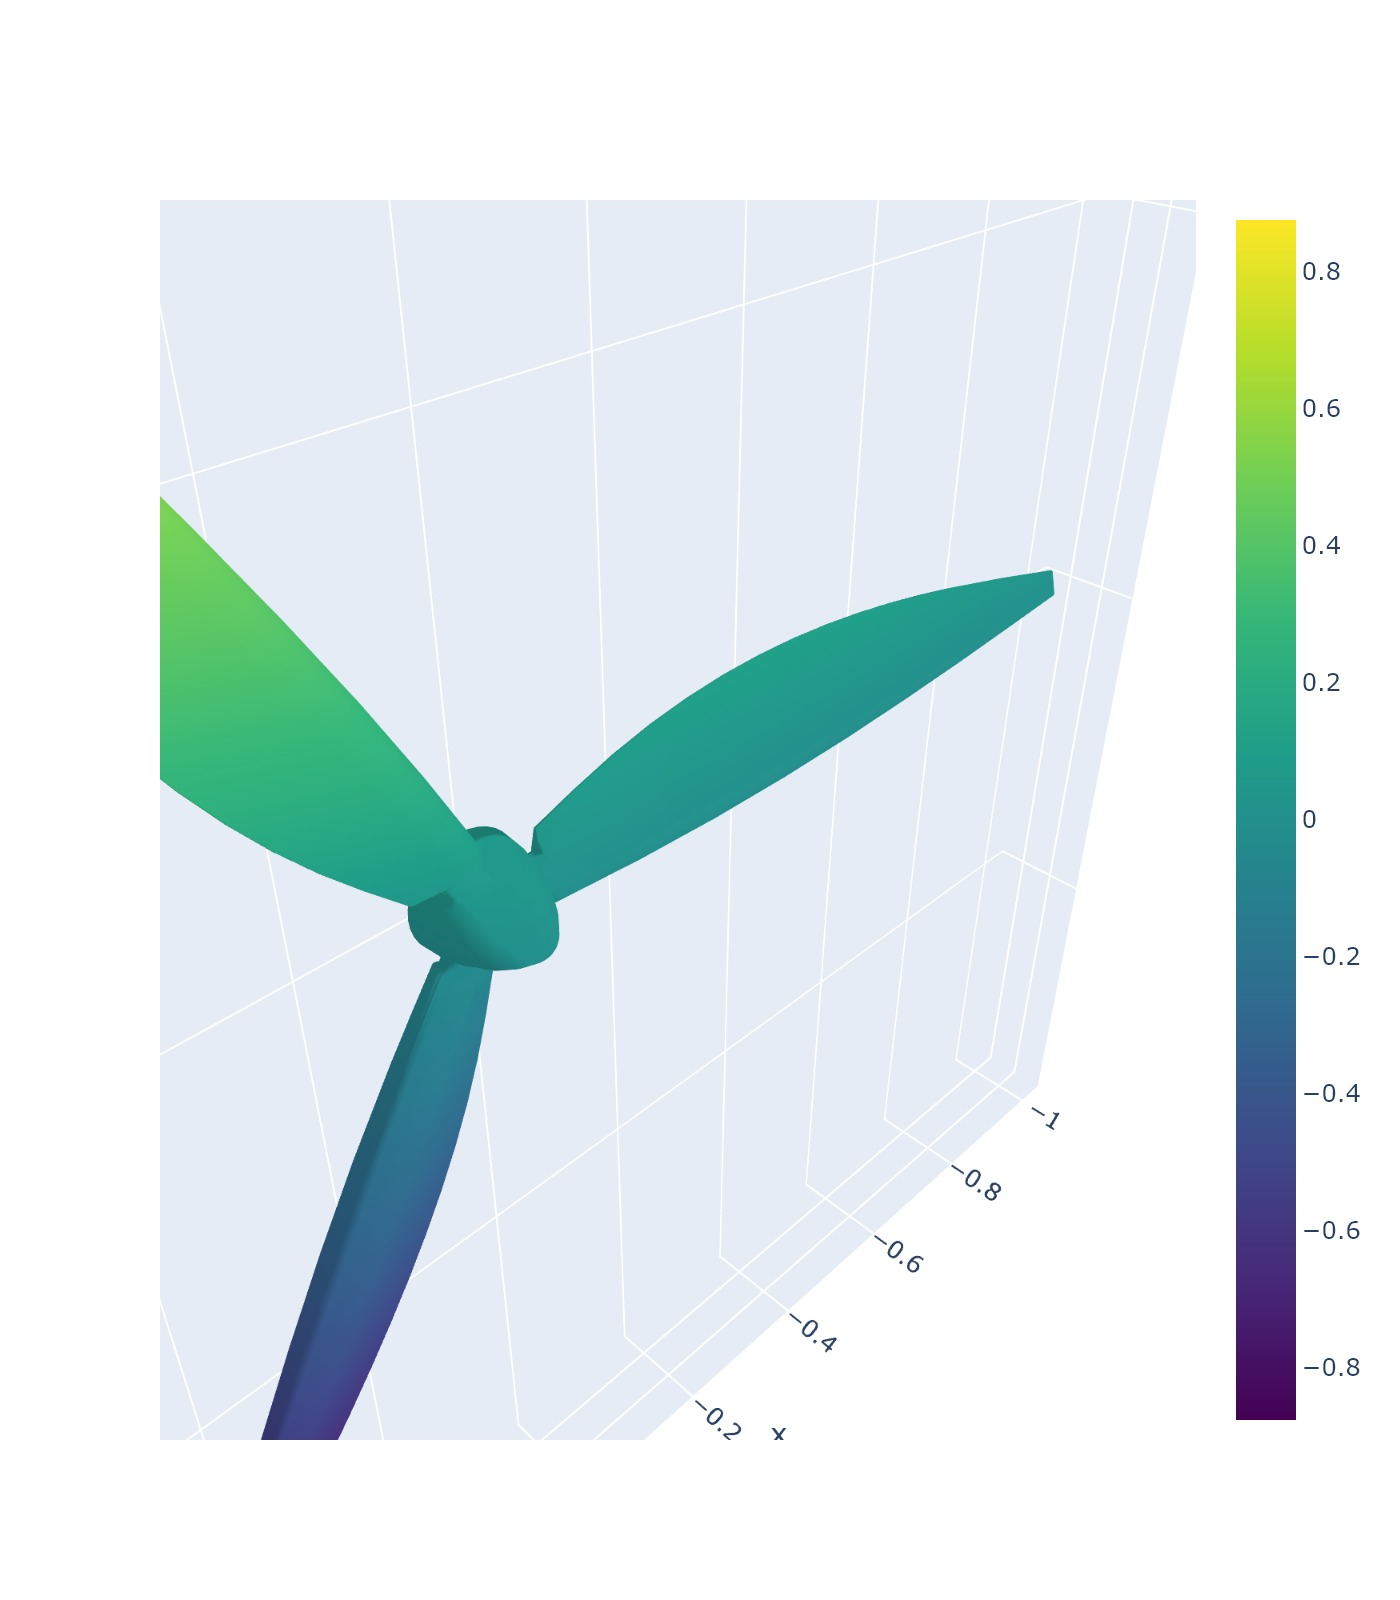

In [7]:
import pymeshlab
import plotly.graph_objs as go
from IPython.display import Image

ms = pymeshlab.MeshSet()
ms.load_new_mesh(target_1["model"])
t_mesh = ms.current_mesh()
v_matrix = np.array(t_mesh.vertex_matrix())
f_matrix = np.array(t_mesh.face_matrix())

fig = go.Figure()
fig.add_trace(
    go.Mesh3d(
        x=v_matrix[:, 0],
        y=v_matrix[:, 1],
        z=v_matrix[:, 2],
        i=f_matrix[:, 0],
        j=f_matrix[:, 1],
        k=f_matrix[:, 2],
        intensity=v_matrix[:, 2],
        colorscale="Viridis",
    )
)
fig["layout"]["scene"]["aspectmode"] = "data"
fig["layout"]["height"] = 800

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

## Radar Scene Simulation

Use the `simulator.sim_radar` module to simulate the baseband samples from the defined radar system and targets. `level='sample'` defines ray tracing for each sample point. This is the most time-consuming setup but the most accurate.

The output baseband data is a dict including the timestamp and baseband. Both of them are 3-D matrix:

`[channels, pulses, ADC samples]`


In [8]:
from radarsimpy.simulator import sim_radar
import time

tic = time.time()
data = sim_radar(radar, targets, density=1, level="pulse")
baseband = data["baseband"] + data["noise"]
toc = time.time()

print("Exec time:", toc - tic, "s")

Exec time: 13.437040328979492 s


## Range-Doppler Processing


In [9]:
from scipy import signal
import radarsimpy.processing as proc

range_window = signal.windows.chebwin(radar.sample_prop["samples_per_pulse"], at=60)
doppler_window = signal.windows.chebwin(
    radar.radar_prop["transmitter"].waveform_prop["pulses"], at=60
)
range_doppler = np.fft.fftshift(
    proc.range_doppler_fft(baseband, rwin=range_window, dwin=doppler_window), axes=1
)

_Plot the micro-Doppler signaure in the range-Doppler map_


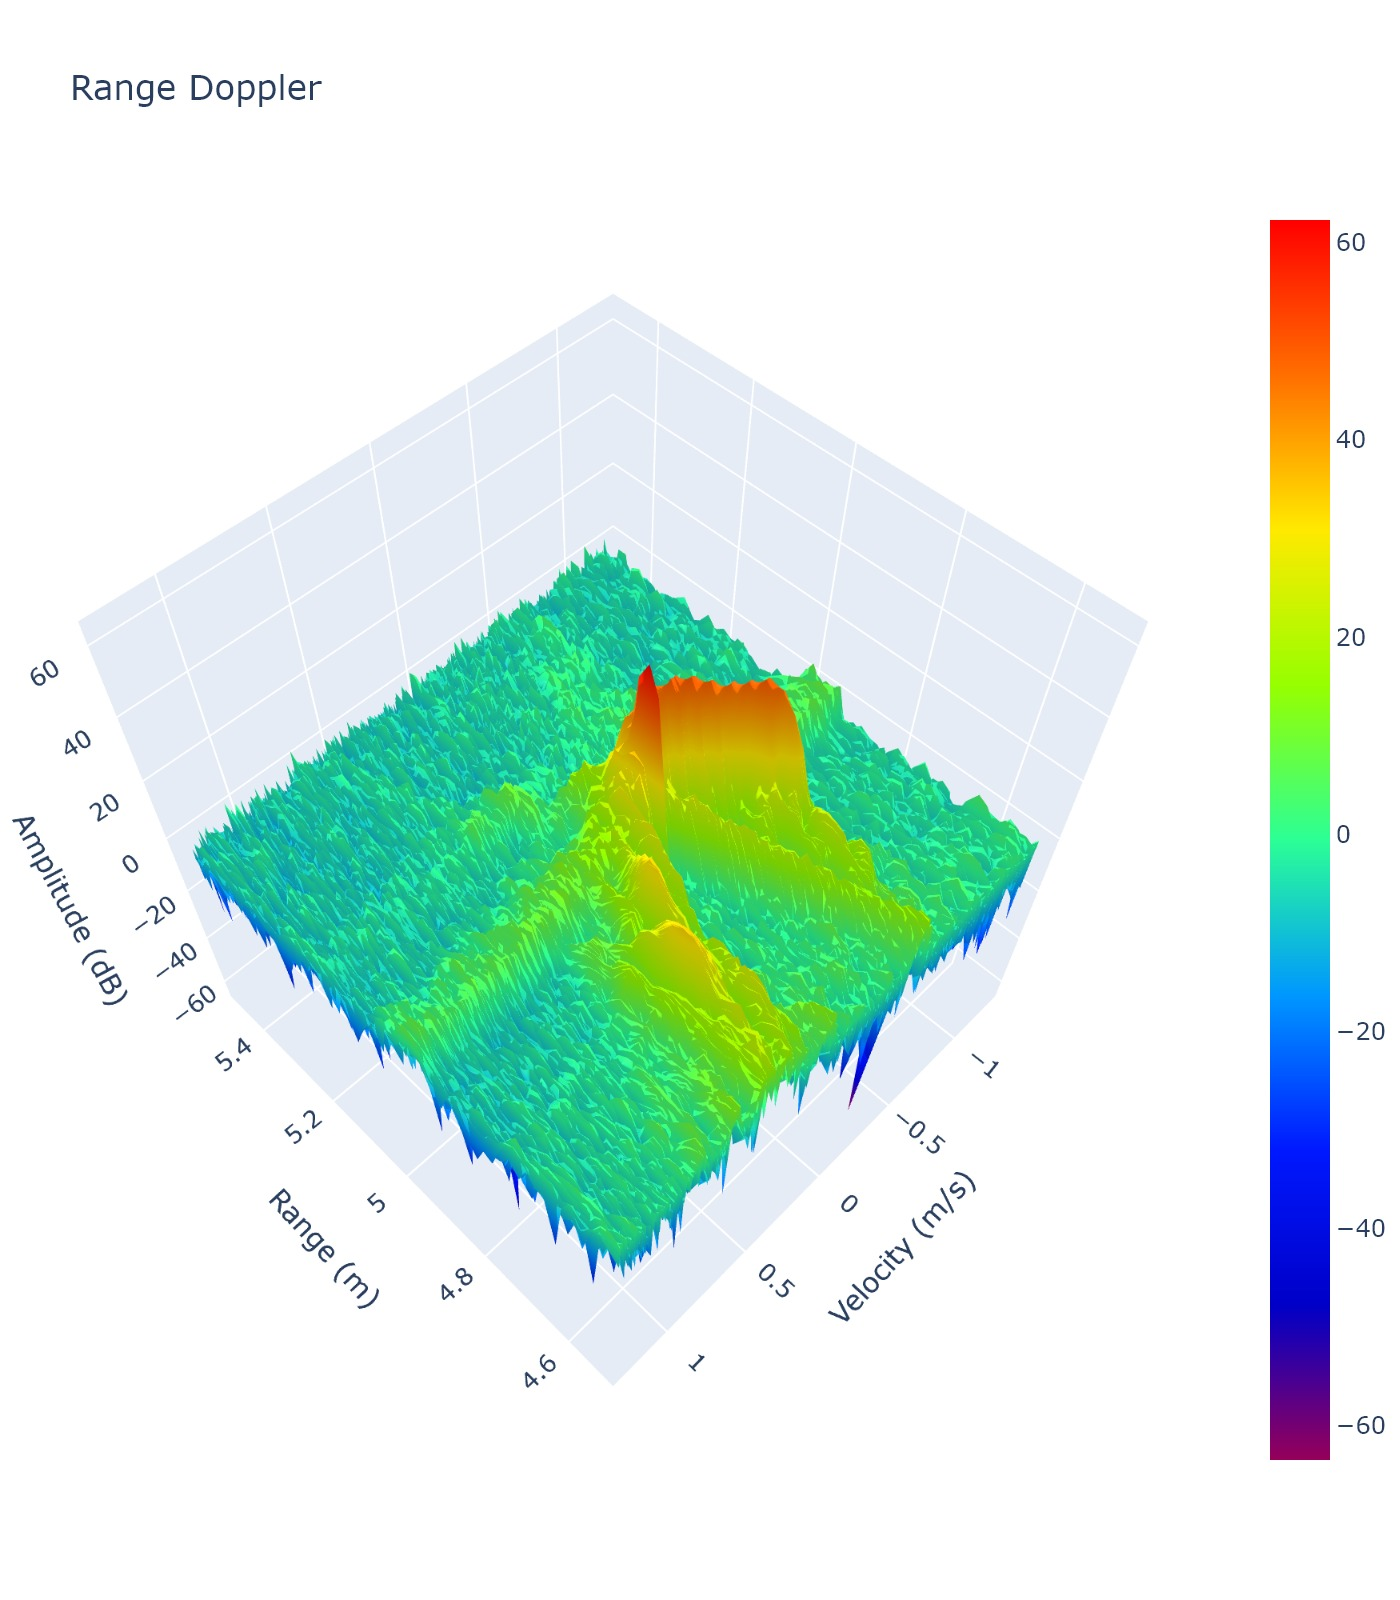

In [10]:
temp = np.abs(range_doppler[0, :, :])
temp = 20 * np.log10(temp)

max_range = (
    3e8
    * radar.radar_prop["receiver"].bb_prop["fs"]
    * radar.radar_prop["transmitter"].waveform_prop["pulse_length"]
    / radar.radar_prop["transmitter"].waveform_prop["bandwidth"]
    / 2
)
unambiguous_speed = (
    3e8 / radar.radar_prop["transmitter"].waveform_prop["prp"][0] / 24e9 / 2
)

range_axis = np.linspace(
    0, max_range, radar.sample_prop["samples_per_pulse"], endpoint=False
)

rng_idx = np.where(np.logical_and(range_axis > 4.5, range_axis < 5.5))

doppler_axis = np.linspace(
    -unambiguous_speed / 2,
    unambiguous_speed / 2,
    radar.radar_prop["transmitter"].waveform_prop["pulses"],
    endpoint=False,
)

fig = go.Figure()

fig.add_trace(
    go.Surface(
        x=range_axis[rng_idx[0]],
        y=doppler_axis,
        z=temp[:, rng_idx[0]],
        colorscale="Rainbow",
    )
)

camera = dict(
    up=dict(x=0, y=0, z=1), center=dict(x=0, y=0, z=0), eye=dict(x=-1, y=1, z=2)
)

fig.update_layout(
    title="Range Doppler",
    height=800,
    scene=dict(
        xaxis=dict(title="Range (m)", range=[4.5, 5.5]),
        yaxis=dict(title="Velocity (m/s)"),
        zaxis=dict(title="Amplitude (dB)"),
        aspectmode="cube",
        camera=camera,
    ),
    margin=dict(l=0, r=0, b=60, t=100),
    legend=dict(orientation="h"),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))